# Analysis of strains grouped by cas subtype
This Notebook generates the following plots:
* Fig. 3A
* Fig. 3B
* Fig. 3C
* Fig. S4A
* Fig. S4B
* Fig. R3

In [1]:
using DelimitedFiles, Random, Statistics, PyPlot
rc(:svg,fonttype=:none)

using NBInclude
@nbinclude("CRISPRCasdb.ipynb")

include("get_repertoires.jl")
include("linreg.jl")
include("bin.jl")

get_freqs_l(lens::Array{Int}; lmin, lmax) = [count(x->x==l,lens) for l in lmin:lmax]

lin(x;m=0,c=0) = m*x + c # linear function

bs = 200 # binsize (NOTE: Fig. 2c used 50)
ml = false;

## Read strains from file
* `gbs_cc.csv`: filtered by species
* `gbs_cc_filter.csv`: filtered by species and additionally to share zero spacers between them (see `analysis-shared-spacers.ipynb`)

Note: gbs are randomly shuffled to eliminate systematic bias when binning.

In [2]:
fc = "filtered/gbs_cc_filter.csv"
# fc = "filtered/gbs_cc.csv"

gbdata = readdlm(fc,',')
p_gbs = randperm(size(gbdata,1))
speciesids = gbdata[p_gbs,1]
gbs = gbdata[p_gbs,2];

## Subtypes with sufficient data for analysis
12 subtypes have >10 species in CRISPRCasdb.

In [3]:
subtypes_s = vcat([["CAS-TypeI"*a for a in ["A","B","C","D","E","F","U"]], # type I
                   ["CAS-TypeII"*a for a in ["A","C"]], # type II
                   ["CAS-TypeIII"*a for a in ["A","B","D"]]]...) # type III

# for labeling plots
subtypes_s1 = vcat([["I-"*a for a in ["A","B","C","D","E","F","U"]], # type I
                    ["II-"*a for a in ["A","C"]], # type II
                    ["III-"*a for a in ["A","B","D"]]]...) # type III

num_s = length(subtypes_s)

# for plotting
ni = 4 # vertical
nj = 3 # horizontal
colors_s = vcat([[get_cmap("Blues",8)(i) for i in 1:7],
                 [get_cmap("Greens",3)(i) for i in 1:2],
                 [get_cmap("Reds",4)(i) for i in 1:3]]...)

# for comparing between the 12 type I, II and III subtypes
PAM_s = vcat(3*ones(9),zeros(3))

# order of subtypes in plots (ordered by 25th percentile of spacer lengths for types II, I, and III)
p_s = [8,9,5,6,3,2,4,7,1,11,12,10];

### subtype &rightarrow; gbs, subtype &rightarrow; no. of gbs
Strains carrying multiple subtypes are assigned to group "M".

In [4]:
s2gbs = Dict{String,Array{String}}(st => gbs[findall(g->genbank2subtype[g]==st,gbs)] for st in subtypes_all)
s2num_gbs = Dict{String,Int}(st => length(s2gbs[st]) for st in subtypes_all)

Dict{String, Int64} with 23 entries:
  "CAS-TypeIIID" => 29
  "CAS-TypeIIIC" => 1
  "CAS-TypeVIB2" => 0
  "CAS-TypeIV"   => 4
  "CAS-TypeIIC"  => 291
  "M"            => 843
  "CAS-TypeIA"   => 22
  "CAS-TypeIF"   => 201
  "CAS-TypeIIA"  => 98
  "CAS-TypeIU"   => 53
  "CAS"          => 22
  "CAS-TypeVIC"  => 0
  "CAS-TypeVIB1" => 1
  "CAS-TypeIE"   => 438
  "CAS-TypeIB"   => 192
  "CAS-TypeIIB"  => 8
  "CAS-TypeVA"   => 8
  "CAS-TypeIIIA" => 32
  "CAS-TypeVIA"  => 0
  "CAS-TypeIC"   => 278
  "CAS-TypeID"   => 19
  "CAS-TypeVB"   => 1
  "CAS-TypeIIIB" => 36

### subtype &rightarrow; repertoire size of each strain, subtype &rightarrow; all spacer lengths of each strain

In [5]:
subtypes_all2 = copy(subtypes_all)
filter!(s->s2num_gbs[s]>0,subtypes_all2) # subtypes with nonzero data;

In [6]:
s2N_gbs = Dict{String,Array{Int}}()
s2lens_gbs = Dict{String,Array{Array{Int}}}()

for s in subtypes_all2
    num_gbs1, repsizes1, spacerlens1 = get_repertoires(s2gbs[s], verbose=0)
    
    s2N_gbs[s] = repsizes1
    s2lens_gbs[s] = spacerlens1
end

## Fig. 3A: Spacer length distributions by subtype
Collate all spacers and plot length distributions for each subtype.

In [7]:
lens_collated_s = [vcat(s2lens_gbs[s]...) for s in subtypes_s]

lmin = 25
lmax = 50

lens_hist_s = [get_freqs_l(lens_collated_s[i], lmin=lmin, lmax=lmax) for i in 1:num_s]

# spacer length quantiles
q10len_s = [round(Int,quantile(lens_collated_s[i], 0.1)) for i in 1:num_s]
q25len_s = [round(Int,quantile(lens_collated_s[i], 0.25)) for i in 1:num_s]
q50len_s = [round(Int,median(lens_collated_s[i])) for i in 1:num_s]
q75len_s = [round(Int,quantile(lens_collated_s[i], 0.75)) for i in 1:num_s]

# meanlen_s = [round(mean(lens_collated_s[i]), digits=1) for i in 1:num_s];

In [8]:
[q25len_s q50len_s]

12×2 Matrix{Int64}:
 37  39
 35  36
 34  34
 35  36
 32  32
 32  32
 35  36
 30  30
 30  30
 36  39
 34  36
 35  37

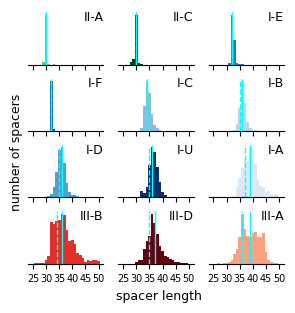

PyObject Text(0.07, 0.28, 'number of spacers')

In [9]:
fig, axs = subplots(ni, nj, figsize=(3.3, 3.3), sharex=true, sharey=false)

fs = 8

for i in 1:ni, j in 1:nj
    n = (i-1)*nj + j
    
    axs[i,j].bar(lmin:lmax, lens_hist_s[p_s[n]], width=1, color=colors_s[p_s[n]])
    
    # indicate median and 25th percentile
    ymin, ymax = axs[i,j].get_ylim()
    axs[i,j].vlines(q25len_s[p_s[n]], 0, ymax, color="cyan", linewidth=1, linestyle="--")
    axs[i,j].vlines(q50len_s[p_s[n]], 0, ymax, color="cyan", linewidth=1)
    
    axs[i,j].set_title(subtypes_s1[p_s[n]], fontsize=fs+1, loc="right", y=0.65)
    axs[i,j].set_xticks(lmin:5:lmax)
    axs[i,j].set_xticklabels(lmin:5:lmax, fontsize=fs-1)
    axs[i,j].set_yticks([])
    
    axs[i,j].spines["top"].set_visible(false)
    axs[i,j].spines["right"].set_visible(false)
    axs[i,j].spines["left"].set_visible(false)
end

fig.text(0.39,0.0,"spacer length", fontsize=fs+1)
fig.text(0.07,0.28,"number of spacers", fontsize=fs+1, rotation="vertical")

# savefig("len_bysubtype.svg",format="svg")

## Fig. 3B: Subtype operative length vs. repertoire size

In [10]:
meanN_s = [mean(s2N_gbs[s]) for s in subtypes_s]
stderrN_s = [std(s2N_gbs[s])/sqrt(s2num_gbs[s]) for s in subtypes_s];

### linear regression

In [11]:
dy = ones(length(meanN_s))
m_fig1b, c_fig1b, dm_fig1b, dc_fig1b = linreg(x=meanN_s, y=q25len_s.+PAM_s, dy=dy)

m1_fig1b = round(m_fig1b, digits=2)
dm1_fig1b = round(dm_fig1b, digits=2);

### plot

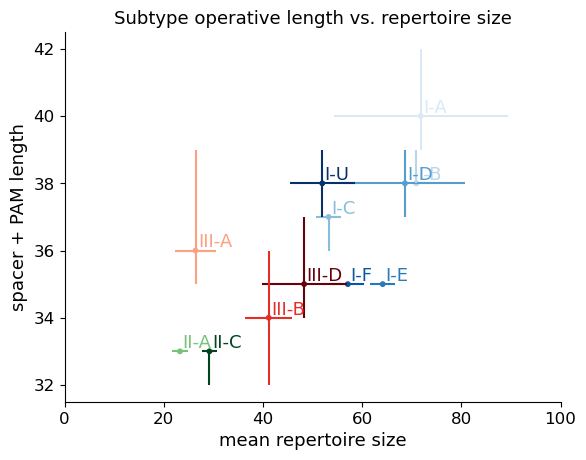

In [12]:
fig, ax = subplots()

# # plot linear fit
# xrange = collect(0:10:100)
# plot(xrange, lin.(xrange, m=m_fig1b, c=c_fig1b), alpha=0.5)

y_offsets = zeros(num_s) # offset points for ease of visualization

errorbar(meanN_s, q25len_s.+PAM_s.+y_offsets, linestyle="none",
    yerr=[q25len_s.-q10len_s, q50len_s.-q25len_s], xerr=stderrN_s,
    elinewidth=1.5, capsize=0, ecolor=colors_s)

scatter(meanN_s, q25len_s.+PAM_s.+y_offsets, s=10, color=colors_s)

fs = 13
for i in 1:num_s
    text(meanN_s[i]+0.5, q25len_s[i]+PAM_s[i]+y_offsets[i]+0.1, subtypes_s1[i], fontsize=fs, color=colors_s[i])
end

ylabel("spacer + PAM length", fontsize=fs)
xlabel("mean repertoire size", fontsize=fs)

xlim(0,100)
xticks(0:20:100, fontsize=fs-1)
ylim(31.5,42.5)
yticks(fontsize=fs-1)

title("Subtype operative length vs. repertoire size", fontsize=fs)
# legend(["fit, \$l = ($m1_fig1b \\pm $dm1_fig1b)\\ N\$ + const."], fontsize=fs-1, loc="upper left")

ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)

# savefig("len_v_N_bysubtype_fit.svg",format="svg")

### 2b.ii) statistical significance of slope and rank correlation
### significance of slope

In [13]:
# num = Int(1e6)

# m_values = zeros(num)

# for i in 1:num
#     m, c, dm, dc = linreg(x=shuffle(meanN_s), y=q25len_s.+PAM_s) # 25th percentile
# #     m, c, dm, dc = linreg(x=shuffle(meanN_s), y=q50len_s.+PAM_s) # median
#     m_values[i] = m
# end

In [14]:
# hist(m_values, bins=-0.15:0.01:0.15)

# ymin, ymax = ylim()

# vlines(m_fig1b, ymin, ymax)
# # vlines(m_fig1b_med, ymin, ymax)

In [15]:
# count(x->x>m_fig1b, m_values)/num
# # count(x->x>m_fig1b_med, m_values)/num

### rank correlation

In [16]:
# ranks of subtypes by operative length and by repertoire size
[sortperm(sortperm(q25len_s .+ PAM_s)) q25len_s .+ PAM_s sortperm(sortperm(meanN_s)) meanN_s]

12×4 Matrix{Float64}:
 12.0  40.0  12.0  71.8182
  9.0  38.0  11.0  70.901
  8.0  37.0   7.0  53.2374
 10.0  38.0  10.0  68.6316
  4.0  35.0   9.0  64.1461
  5.0  35.0   8.0  57.1194
 11.0  38.0   6.0  51.9623
  1.0  33.0   1.0  23.2653
  2.0  33.0   3.0  29.2131
  7.0  36.0   2.0  26.4062
  3.0  34.0   4.0  41.1667
  6.0  35.0   5.0  48.3103

In [17]:
p_len_s = [12,10,8,10,5,5,10,1.5,1.5,7,3,5]
p_N_s = [12,11,7,10,9,8,6,1,3,2,4,5]

spearman_s = cor(p_len_s,p_N_s)

0.7460988895940301

In [18]:
p_fig_s = [9,6,5,7,3,4,8,1,2,12,10,11]

cor(p_len_s,p_fig_s)

0.42278937076995043

In [19]:
# # p-value
# num = 0
# for i in 1:Int(1e6)
#     if cor(p_len_s,shuffle(p_N_s)) > spearman_s
#         num += 1
#     end
# end

# num/1e6

## Fig. 3C: Incidence of cas subtypes in multiple-subtype strains binned into 3 repertoire size bins
### bin multiple-subtype strains

In [20]:
binsize = 281

ml = false

inds_inbins_m = bin_equalheight(s2N_gbs["M"], binsize=binsize, mergelast=ml);

In [21]:
# check repertoire size ranges in each of the 3 bins
[[minimum(s2N_gbs["M"][inds_inbins_m[i]]),maximum(s2N_gbs["M"][inds_inbins_m[i]])] for i in 1:3]

3-element Vector{Vector{Int64}}:
 [1, 72]
 [72, 142]
 [142, 812]

### number of times each cas subtype appears in each bin

In [22]:
# get all subtypes in each of the multiple-subtype strains
subtypes_m = [[caslocus2subtype[c] for c in genbank2casloci[gb]] for gb in s2gbs["M"]];

In [23]:
usage_cas_inbins_m = zeros(Int,num_s,3)

for b in 1:3 # each bin
    for ind in inds_inbins_m[b] # each strain in bin
        for i in 1:num_s # each subtype
            if in(subtypes_s[i],subtypes_m[ind]) # each subtype is counted at most once per strain
                usage_cas_inbins_m[i,b] += 1
            end
        end
    end
end

### normalize by number of occurrences of each subtype

In [24]:
frac_usage_cas_inbins_m = usage_cas_inbins_m./sum(usage_cas_inbins_m,dims=2);

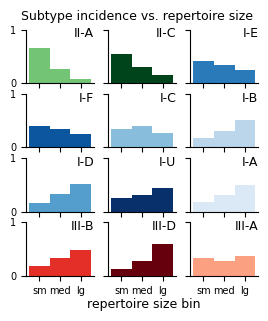

PyObject Text(0.33, 0.01, 'repertoire size bin')

In [25]:
fig, axs = subplots(ni, nj, figsize=(3, 3.2), sharex=true, sharey=true)

fs = 8

for i in 1:ni, j in 1:nj
    n = (i-1)*nj + j
    
    axs[i,j].bar(1:3, frac_usage_cas_inbins_m[p_s[n],:], width=1, color=colors_s[p_s[n]])
    
    axs[i,j].set_title(subtypes_s1[p_s[n]], fontsize=fs+1, loc="right", y=0.7)
    axs[i,j].set_xticks(1:3)
    axs[i,j].set_xticklabels(["sm","med","lg"], fontsize=fs-1)
    axs[i,j].set_ylim(0,1)
    axs[i,j].set_yticks([0,1])
    axs[i,j].set_yticklabels(["0","1"], fontsize=fs-1)
    
    axs[i,j].spines["top"].set_visible(false)
    axs[i,j].spines["right"].set_visible(false)
end

fig.text(0.11,0.91,"Subtype incidence vs. repertoire size", fontsize=fs+1)
fig.text(0.33,0.01,"repertoire size bin", fontsize=fs+1)

# savefig("usage_castype_m.svg",format="svg")

### rank order subtypes by relative incidence in repertoire size bins

In [26]:
ratio_usage_s = frac_usage_cas_inbins_m[:,3]./frac_usage_cas_inbins_m[:,1];

In [27]:
p_ratio_s = [10,9,5,11,3,4,7,1,2,6,8,12];

In [28]:
# p = sortperm(ratio_usage_s)
# [p ratio_usage_s[p]]

In [29]:
spearman_ratio_s = cor(p_len_s,p_ratio_s)

0.6288547783721111

In [30]:
# p-value
num = 0
for i in 1:Int(1e6)
    if cor(p_len_s,shuffle(p_ratio_s)) > spearman_ratio_s
        num += 1
    end
end

num/1e6

0.015267

### only type I subtypes

In [31]:
p_len_I = [7,5,3,5,1.5,1.5,5]
p_ratio_I = [6,5,3,7,1,2,4];

In [32]:
# p = sortperm(q25len_s[1:7])
# [p q25len_s[1:7][p]]

# p = sortperm(ratio_usage_s[1:7])
# [p ratio_usage_s[1:7][p]]

In [33]:
spearman_ratio_I = cor(p_len_I, p_ratio_I)

0.8794653965640157

In [34]:
# p-value
num = 0
for i in 1:Int(1e6)
    if cor(p_len_I,shuffle(p_ratio_I)) > spearman_ratio_I
        num += 1
    end
end

num/1e6

0.004749

## Fig. S4A: Incidence of spacer lengths in 3 repertoire size bins
### number of spacers of each length appearing in each bin

In [35]:
lranges = vcat(collect(30:2:38),1000)

usage_l_inbins_m = zeros(Int,6,3)

for b in 1:3 # each bin
    for ind in inds_inbins_m[b] # each strain in bin
        for l in s2lens_gbs["M"][ind] # each spacer length in strain
            usage_l_inbins_m[findfirst(x->l<=x,lranges),b] += 1
        end
    end
end

### normalize by total number of spacers in each bin

In [36]:
totnumspacers = sum(usage_l_inbins_m,dims=1)

frac_usage_l_inbins_m = usage_l_inbins_m./totnumspacers;

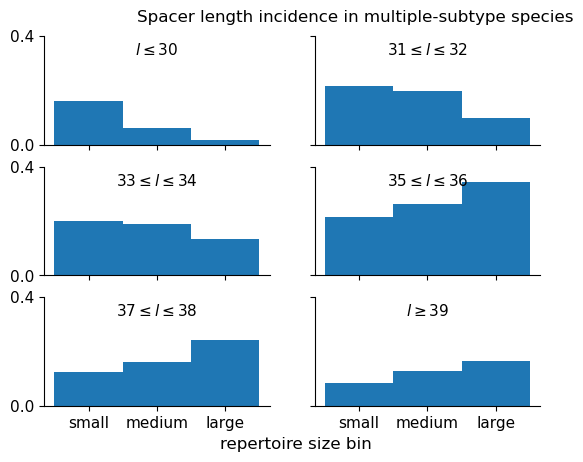

PyObject Text(0.4, 0.02, 'repertoire size bin')

In [37]:
ni2 = 3
nj2 = 2
fig, axs = subplots(ni2, nj2, sharex=true, sharey=true)

fs = 11
l_text = ["\$l \\leq 30\$",
          "\$31 \\leq l \\leq 32\$",
          "\$33 \\leq l \\leq 34\$",
          "\$35 \\leq l \\leq 36\$",
          "\$37 \\leq l \\leq 38\$",
          "\$l \\geq 39\$"]

for i in 1:ni2, j in 1:nj2
    n = (i-1)*nj2 + j
    
    axs[i,j].bar(1:3, frac_usage_l_inbins_m[n,:], width=1)
    
    axs[i,j].set_title(l_text[n], fontsize=fs, loc="center", y=0.75)
    axs[i,j].set_xticks(1:3)
    axs[i,j].set_xticklabels(["small","medium","large"], fontsize=fs)
    axs[i,j].set_ylim(0,0.4)
    axs[i,j].set_yticks([0,0.4])
    axs[i,j].set_yticklabels([0,0.4], fontsize=fs)
    
    axs[i,j].spines["top"].set_visible(false)
    axs[i,j].spines["right"].set_visible(false)
end

fig.text(0.27,0.91,"Spacer length incidence in multiple-subtype species", fontsize=fs+1)
fig.text(0.4,0.02,"repertoire size bin", fontsize=fs+1)

# savefig("usage_l_m.svg",format="svg")

## Fig. S4B: Incidence of cas subtypes across repertoire size bins
### quantities for plotting Fig. 2C

In [38]:
num_gbs, repsizes, spacerlens = get_repertoires(gbs)
mspacerlens = mean.(spacerlens)

inds_inbins_cc = bin_equalheight(repsizes, binsize=bs, mergelast=ml)

mean_logN_inbins_cc = [mean(log10.(repsizes[inds])) for inds in inds_inbins_cc]
stderr_logN_inbins_cc = [std(log10.(repsizes[inds]))/sqrt(length(inds)) for inds in inds_inbins_cc]

mean_l_inbins_cc = [mean(mspacerlens[inds]) for inds in inds_inbins_cc]
stderr_l_inbins_cc = [std(mspacerlens[inds])/sqrt(length(inds)) for inds in inds_inbins_cc]

num_bins_cc = length(inds_inbins_cc)

2577 repertoires returned.


13

In [39]:
m_fit, c_fit, dm_fit, dc_fit = linreg(x=log10.(repsizes), y=mspacerlens)

(2.1758408170354957, 30.116426869660494, 0.12103355069410035, 0.2117072162747804)

### incidence of cas subtypes in each repsize bin

In [40]:
usage_cas_inbins_s = zeros(Int,num_s,num_bins_cc)

for b in 1:num_bins_cc # each bin
    for ind in inds_inbins_cc[b] # each strain in bin
        gb = gbs[ind]
        st = genbank2subtype[gb]
        if st != "M" && in(st,subtypes_s)
            usage_cas_inbins_s[findfirst(x->x==st, subtypes_s),b] += 1
        else
            sts = unique([caslocus2subtype[c] for c in genbank2casloci[gb]]) # each subtype is counted at most once per strain
            filter!(in(subtypes_s),sts)
            for st in sts
                usage_cas_inbins_s[findfirst(x->x==st, subtypes_s),b] += 1
            end
        end
    end
end

In [41]:
# normalize by number of species in each bin
frac_usage_cas_inbins_s = usage_cas_inbins_s./length.(inds_inbins_cc)';

### plot analogue of Fig. 2C

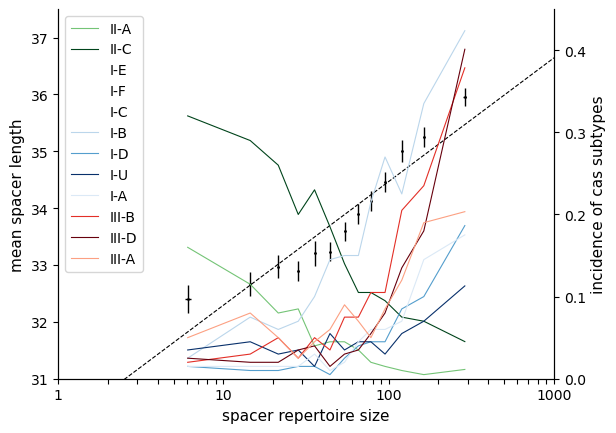

In [42]:
fig, ax1 = subplots()

# plot mean and standard error of binned data
ax1.errorbar(mean_logN_inbins_cc,mean_l_inbins_cc, linestyle="none",marker="o",markersize=1,
    xerr=stderr_logN_inbins_cc,yerr=stderr_l_inbins_cc, elinewidth=1,capsize=0, color="black")

# plot linear fit
xrange = collect(0:0.1:3)
ax1.plot(xrange,lin.(xrange, m=m_fit, c=c_fit), linewidth=0.8, linestyle="--", color="black")

fs = 11

xtick_vals = log10.(vcat(collect(1:10),collect(20:10:100),collect(200:100:1000)))
xtick_labels = string.(vcat(["1"],fill("",8),["10"],fill("",8),["100"],fill("",8),["1000"]))
ax1.set_xticks(xtick_vals)
ax1.set_xticklabels(xtick_labels, fontsize=fs-1)
ax1.set_xlabel("spacer repertoire size", fontsize=fs)
ax1.set_xlim(0,3)

ax1.set_ylim(31,37.5)
ax1.set_ylabel("mean spacer length", fontsize=fs)
ax1.set_yticks(31:37)
ax1.set_yticklabels(31:37, fontsize=fs-1)

ax2 = ax1.twinx()

# lineon = fill("-",num_s)
lineon = fill("none",num_s)
lineon[findall(x->in(x,["I-B","I-A","I-U","I-D","II-A","II-C","III-A","III-B","III-D"]),subtypes_s1)] .= "-" # which lines to plot

xrange = collect(0:0.1:3)
for s in (1:num_s)[p_s]
#     m_s, c_s, dm_s, dc_s = linreg(x=mean_logN_inbins_cc, y=frac_usage_cas_inbins_s[s,:])
    
#     plot(xrange,lin.(xrange, m=m_s, c=c_s), color=colors_s[s])
    
    ax2.plot(mean_logN_inbins_cc, frac_usage_cas_inbins_s[s,:], color=colors_s[s], linestyle=lineon[s], linewidth=0.8)
#     ax2.scatter(mean_logN_inbins_cc, frac_usage_cas_inbins_s[s,:], color=colors_s[s], s=1)
end

ax2.set_ylim(0,0.45)
ax2.set_ylabel("incidence of cas subtypes", fontsize=fs)
ax2.set_yticks(0:0.1:0.4)
ax2.set_yticklabels(0:0.1:0.4, fontsize=fs-1)

legend(subtypes_s1[p_s], fontsize=fs-1, loc="upper left")

# legend(["fit, \$\\ln\\,N = ($propconst1 \\pm $dpropconst1)\\ l_s\$ + const.",
#         "data (species with cas)"], fontsize=fs, loc="upper left")

ax1.spines["top"].set_visible(false)
ax2.spines["top"].set_visible(false)

# savefig("fit-with-subtypes.svg",format="svg")

## Fig. R3: Compare within subtypes with broad length distributions
### type I subtypes with broad length distributions

In [43]:
num_bins = 3

subtypes_I_broad = ["CAS-TypeI"*a for a in ["A","B","C","D","U"]]
subtypes_I_broad1 = ["I-"*a for a in ["A","B","C","D","U"]]
colors_I_broad = [get_cmap("Blues",6)(i) for i in 1:5]

binsizes_I_broad_bysubtype = [ceil(Int,s2num_gbs[s]/num_bins) for s in subtypes_I_broad]

inds_inbins_I_broad_bysubtype = Array[]

for i in 1:5
    s = subtypes_I_broad[i]
    b = binsizes_I_broad_bysubtype[i]
    
    inds_inbins = bin_equalheight(s2N_gbs[s], binsize=b, mergelast=false)
    
    push!(inds_inbins_I_broad_bysubtype, inds_inbins)
end

In [44]:
lens_collated_I_broad_bysubtype = [[vcat(s2lens_gbs[subtypes_I_broad[i]][inds_inbins_I_broad_bysubtype[i][b]]...) for b in 1:num_bins] for i in 1:5]

Ns_collated_I_broad_bysubtype = [[s2N_gbs[subtypes_I_broad[i]][inds_inbins_I_broad_bysubtype[i][b]] for b in 1:num_bins] for i in 1:5]

lens_hist_I_broad_bysubtype = [[get_freqs_l(lens_collated_I_broad_bysubtype[i][b], lmin=lmin, lmax=lmax) for b in 1:num_bins] for i in 1:5];

In [45]:
q25len_I_broad_bysubtype = [[round(Int,quantile(lens_collated_I_broad_bysubtype[i][b], 0.25)) for b in 1:num_bins] for i in 1:5]
q50len_I_broad_bysubtype = [[round(Int,median(lens_collated_I_broad_bysubtype[i][b])) for b in 1:num_bins] for i in 1:5];

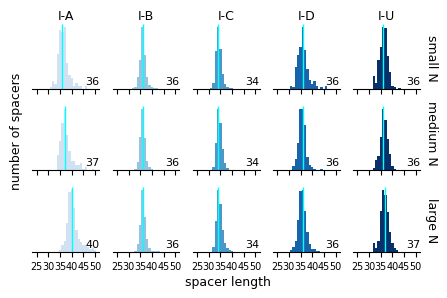

PyObject Text(0.43, 0, 'spacer length')

In [46]:
fig, axs = subplots(num_bins, 5, figsize=(5, 3), sharex=true, sharey=false)

fs = 8

for i in 1:num_bins, j in 1:5
    s = subtypes_I_broad[j]
    
    axs[i,j].bar(lmin:lmax, lens_hist_I_broad_bysubtype[j][i], width=1, color=colors_I_broad[j])
    
    # indicate median and 25th percentile
    ymin, ymax = axs[i,j].get_ylim()
#     axs[i,j].vlines(q25len_I_broad_bysubtype[j][i], 0, ymax, color="cyan", linewidth=1, linestyle="--")
    axs[i,j].vlines(q50len_I_broad_bysubtype[j][i], 0, ymax, color="cyan", linewidth=1)
    axs[i,j].set_title("$(q50len_I_broad_bysubtype[j][i])", fontsize=fs, loc="right", y=-0.05)
    
#     axs[i,j].set_title(subtypes_I_broad1[j], fontsize=fs, loc="right", y=0.65)
    axs[i,j].set_xticks(lmin:5:lmax)
    axs[i,j].set_xticklabels(lmin:5:lmax, fontsize=fs-1)
    axs[i,j].set_yticks([])
    
    if i==1
        axs[i,j].set_title(subtypes_I_broad1[j], fontsize=fs+1, loc="center", y=0.9)
    end
    
    axs[i,j].spines["top"].set_visible(false)
    axs[i,j].spines["right"].set_visible(false)
    axs[i,j].spines["left"].set_visible(false)
end

fig.text(0.91,0.69,"small N", fontsize=fs+1, rotation=270)
fig.text(0.91,0.41,"medium N", fontsize=fs+1, rotation=270)
fig.text(0.91,0.15,"large N", fontsize=fs+1, rotation=270)
fig.text(0.08,0.33,"number of spacers", fontsize=fs+1, rotation="vertical")
fig.text(0.43,0,"spacer length", fontsize=fs+1)

# savefig("len_bysubtype_I.svg",format="svg")

### type III subtypes

In [47]:
subtypes_III = ["CAS-TypeIII"*a for a in ["A","B","D"]]
subtypes_III1 = ["III-"*a for a in ["A","B","D"]]
colors_III = [get_cmap("Reds",4)(i) for i in 1:3]

binsizes_III_bysubtype = [13,13,11]

inds_inbins_III_bysubtype = Array[]

for i in 1:3
    s = subtypes_III[i]
    b = binsizes_III_bysubtype[i]
    
    inds_inbins = bin_equalheight(s2N_gbs[s], binsize=b, mergelast=false)
    
    push!(inds_inbins_III_bysubtype, inds_inbins)
end

In [48]:
lens_collated_III_bysubtype = [[vcat(s2lens_gbs[subtypes_III[i]][inds_inbins_III_bysubtype[i][b]]...) for b in 1:num_bins] for i in 1:3]

Ns_collated_III_bysubtype = [[s2N_gbs[subtypes_I_broad[i]][inds_inbins_I_broad_bysubtype[i][b]] for b in 1:num_bins] for i in 1:5]

lens_hist_III_bysubtype = [[get_freqs_l(lens_collated_III_bysubtype[i][b], lmin=lmin, lmax=lmax) for b in 1:num_bins] for i in 1:3];

In [49]:
q25len_III_bysubtype = [[round(Int,quantile(lens_collated_III_bysubtype[i][b], 0.25)) for b in 1:num_bins] for i in 1:3]
q50len_III_bysubtype = [[round(Int,median(lens_collated_III_bysubtype[i][b])) for b in 1:num_bins] for i in 1:3];

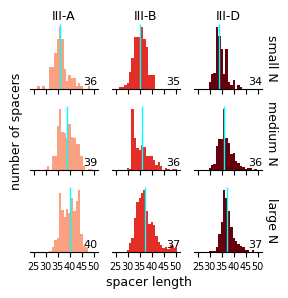

PyObject Text(0.38, 0, 'spacer length')

In [50]:
fig, axs = subplots(num_bins, 3, figsize=(3, 3), sharex=true, sharey=false)

fs = 8

for i in 1:num_bins, j in 1:3
    s = subtypes_III[j]
    
    axs[i,j].bar(lmin:lmax, lens_hist_III_bysubtype[j][i], width=1, color=colors_III[j])
    
    # indicate median and 25th percentile
    ymin, ymax = axs[i,j].get_ylim()
#     axs[i,j].vlines(q25len_III_bysubtype[j][i], 0, ymax, color="cyan", linewidth=1, linestyle="--")
    axs[i,j].vlines(q50len_III_bysubtype[j][i], 0, ymax, color="cyan", linewidth=1)
    axs[i,j].set_title("$(q50len_III_bysubtype[j][i])", fontsize=fs, loc="right", y=-0.05)
    
#     axs[i,j].set_title(subtypes_III1[j], fontsize=fs, loc="right", y=0.65)
    axs[i,j].set_xticks(lmin:5:lmax)
    axs[i,j].set_xticklabels(lmin:5:lmax, fontsize=fs-1)
    axs[i,j].set_yticks([])
    
    if i==1
        axs[i,j].set_title(subtypes_III1[j], fontsize=fs+1, loc="center", y=0.9)
    end
    
    axs[i,j].spines["top"].set_visible(false)
    axs[i,j].spines["right"].set_visible(false)
    axs[i,j].spines["left"].set_visible(false)
end

fig.text(0.91,0.69,"small N", fontsize=fs+1, rotation=270)
fig.text(0.91,0.41,"medium N", fontsize=fs+1, rotation=270)
fig.text(0.91,0.15,"large N", fontsize=fs+1, rotation=270)
fig.text(0.06,0.33,"number of spacers", fontsize=fs+1, rotation="vertical")
fig.text(0.38,0,"spacer length", fontsize=fs+1)

# savefig("len_bysubtype_III.svg",format="svg")